# Assignment 2
## Exercise 1 + 2 + 3
First we adding some imports that we are going to use define the provided functions of `mnist-helper.py`.

In [1]:
import struct
import os
from urllib.request import urlopen
from urllib.parse import urlparse, urljoin
import numpy as np
import gzip
from gzip import GzipFile
# make all of ths reproducible
np.random.seed(1)

import tensorflow as tf
import matplotlib.pylab as plt
import time
from IPython import display
%matplotlib inline
    
from math import sqrt
from tensorflow import truncated_normal_initializer

In [2]:
class MNISTLoader():
    '''``MNISTLoader`` class can load MNIST dataset from the web or disk.

    Attributes
    ----------
    training_data_name  :   str
                            Name of the train data file
    test_data_name  :   str
                        Name of the test data file
    training_labels_name    :   str
                                Name of the train labels file
    test_labels_name    :   str
                            Name of the test labels file
    data_folder :   str
                    Name of the folder to save data in
    training_data   :   np.ndarray
                        Numpy array with the training data
    test_data   :   np.ndarray
                    Numpy array with the test data
    training_labels :   np.ndarray
                        Training labels
    test_labels :   np.ndarray
                    Test labels
    '''
    def __init__(self, directory='data', base_link='http://yann.lecun.com/exdb/mnist/'):
        '''Initialise loader.

        Parameters
        ----------
        directory   :   str
                        Directory to save downloaded data to
        base_link   :   str
                        Uri forming the base for all data parts. File names will
                        be appended to this base
        '''
        self.training_data_name = 'train-images-idx3-ubyte.gz'
        self.training_labels_name = 'train-labels-idx1-ubyte.gz'
        self.test_data_name = 't10k-images-idx3-ubyte.gz'
        self.test_labels_name = 't10k-labels-idx1-ubyte.gz'

        self.data_folder = directory

        # if folder doesn't exist yet, create it and download
        if not os.path.exists(self.data_folder):
            os.mkdir(self.data_folder)
            # helper to shorten url creation
            url = lambda name: urljoin(base_link, name)
            self.test_data = self._load(url(self.test_data_name), False, True)
            self.test_labels = self._load(url(self.test_labels_name),
                                          True, True)
            self.training_data = self._load(url(self.training_data_name),
                                            False, True)
            self.training_labels = self._load(url(self.training_labels_name),
                                              True, True)
        # else simply load from disk
        else:
            # helper to shorten path creation
            path = lambda name: os.path.join(directory, name)
            self.test_data = self._load(path(self.test_data_name))
            self.test_labels = self._load(path(self.test_labels_name), True)
            self.training_data = self._load(path(self.training_data_name))
            self.training_labels = self._load(path(self.training_labels_name), True)

    def _load(self, path_or_url, labels=False, save=False):
        '''Load the MNIST data set, either from disk or from the web.

        Parameters
        ----------
        path_or_url :   str
                        Url of the file, or filesystem path
        labels  :   bool
                    Whether or not the file contains labels as opposed to data
        save    :   bool
                    Serialize the data to disk (useless if fetching locally)

        Returns
        -------
        np.ndarray
                Data (in shape (N, 28, 28)) or labels (in shape (N))
        '''

        # we unify loading from web and file system by creating file:// uris for
        # local files and just using urllib on them as well
        parse_result = urlparse(path_or_url)
        if not parse_result.scheme:
            # looks like a file
            if not os.path.exists(path_or_url):
                raise RuntimeError('Found data directory, but not %s in it. '
                                   'Remove it and restart' % path_or_url)
            path_or_url = 'file://' + os.path.abspath(path_or_url)
        else:
            print('Downloading from web...')
        print(path_or_url)
        # stream over tcp/file
        with urlopen(path_or_url) as request_stream:
            zip_file = GzipFile(fileobj=request_stream, mode='rb')
            zip_name = os.path.join(self.data_folder, os.path.basename(path_or_url))
            if save:
                # first save the file
                with gzip.open(zip_name, mode='wb') as f:
                    f.write(zip_file.read())
            # then read it back in and fill data
            # note we cannot simply seek(0) above since this isn't a real file
            # but a web resource
            with gzip.open(zip_name, mode='rb') as fd:
                # first unpack magic numer and number of elements (4 bytes each)
                magic, numberOfItems = struct.unpack('>ii', fd.read(2 * 4))
                if (not labels and magic != 2051) or (labels and magic != 2049):
                    raise LookupError('Not a MNIST file')
                if not labels:
                    # then unpack format
                    rows, cols = struct.unpack('>II', fd.read(8))
                    # to use np.frombuffer, we need a bytearray, doesn't work
                    # directly from file
                    b = bytearray(fd.read())
                    images = np.frombuffer(b, dtype='uint8')
                    images = images.reshape((numberOfItems, rows, cols))
                    return images
                else:
                    b = bytearray(fd.read())
                    labels = np.frombuffer(b, dtype='uint8')
                    return labels

    def batches(self, data, labels, batch_size):
        '''Generate a set of random minibatches from the given data.

        Parameters
        ----------
        data    :   np.ndarray
                    Data array
        lablels :   np.ndarray
                    Labels vectory
        batch_size  :   int
                        Size of the minibatches (must be > 0)

        Yields
        ------
        tuple
            Tuples of (data_batch, labels_batch), the union of which exactly
            equals the data set
        '''
        samples_n = labels.shape[0]
        if batch_size <= 0:
            batch_size = samples_n

        random_indices = np.random.choice(samples_n, samples_n, replace=False)
        data = data[random_indices]
        labels = labels[random_indices]
        for i in range(samples_n // batch_size):
            on = i * batch_size
            off = on + batch_size
            yield data[on:off], labels[on:off]



## Exercise 4
Here we are inspecting the data.

In [3]:
def plot_mnist_digits(*digits_labels):
    '''Plot an aribtrary number of mnis digits on an automatic grid.

    Parameters
    ----------
    digits_labels   :   list
                        List of tuples (np.ndarray, int) giving an image of
                        shape (28, 28) and a label
    Returns
    -------
    pyplot.Figure
            Figure with digits drawn into the only axes
    '''
    num = len(digits_labels)
    # try a square shape, but round to the nearest integer (down for rows, up
    # for cols)
    rows = int(sqrt(num))
    cols = int(num / rows + 0.5)
    f, axarr = plt.subplots(rows, cols)
    for row in range(rows):
        for col in range(cols):
            ax = axarr[row][col]
            # linear index from two indeces
            index = row * rows + col
            ax.imshow(digits_labels[index][0], cmap='gray')
            # place class label to the left of plot
            ax.set_title(digits_labels[index][1], x=-0.1, y=0.5)
            # remove the ticks (pointless for images)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    return f

## Exercise 5
Create the data flow graph (DFG).

In [4]:
# Reset graph in order to cope with multiple cell executions.
tf.reset_default_graph()

# Weight matrix
mean = 0.0
std = 0.000002
W = tf.get_variable('weights', initializer=truncated_normal_initializer(mean, std, seed=1), shape=[28 * 28, 10])

# bias vector
b = tf.get_variable('bias', initializer=tf.zeros_initializer(), shape=[10])

# data vector
x = tf.placeholder(tf.float32, [None, 28 * 28], name='input')

# desired output (ie real labels)
d = tf.placeholder(tf.int32, [None, 1], name='labels')
# one-hot encoding produces a vecor of shape (batch, 1, 10) instead of (batch, 10)
d_1_hot = tf.squeeze(tf.one_hot(d, 10), axis=1)

# computed output of the network without activation
y = tf.matmul(x, W) + b

# loss function
cross_entropy      = tf.nn.softmax_cross_entropy_with_logits(logits = y, labels = d_1_hot)
mean_cross_entropy = tf.reduce_mean(cross_entropy)
# The optimizer should minimize the cross_entropy.
optimizer          = tf.train.GradientDescentOptimizer(learning_rate = 1e-5)#0.5)
training_step      = optimizer.minimize(cross_entropy)

## Exercise 6 + 7
Now we are training the network and store all the results.

In [5]:
# load the data
loader = MNISTLoader()
d_train, l_train, d_test, l_test = (loader.training_data,
                                    loader.training_labels,
                                    loader.test_data, loader.test_labels)

# The data comes in image format, which we flatten
d_test  = np.reshape(d_test, (-1, 28 * 28))
d_train = np.reshape(d_train, (-1, 28 * 28))

# The labels only have 1 dimensions, we need to blow it up to 2
l_test  = l_test[:, np.newaxis]
l_train = l_train[:, np.newaxis]

# check if neuron firing strongest coincides with max value position in real labels
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(d_1_hot, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# record accuracy
training_step_accuracy = []
test_step_accuracy     = []

# record cross-entropy
training_step_entropy = []
test_step_entropy     = []

# record weights
weights = []

# Specify number of epochs and the batch size
n_epochs   = 3
batch_size = 5000
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    i = 0
    for epoch in range(n_epochs):
        print('Epoch %d' % epoch)
        for mb, labels in loader.batches(d_train, l_train, batch_size):
            # pass a dict to later retrieve tensors by name. We need the
            # weights only for the record
            values = sess.run(
                {'weights': W, 'step': training_step},
                feed_dict={x: mb, d: labels})
            if i % 10 == 0:
                # run the ops that will give us accuracies and entropies
                # (not needed otherwise)
                current_train_accuracy = sess.run(
                    accuracy, feed_dict={x: d_train, d: l_train})
                current_test_accuracy = sess.run(
                    accuracy, feed_dict={x: d_test, d: l_test})

                training_step_accuracy.append(current_train_accuracy)
                test_step_accuracy.append(current_test_accuracy)

                current_train_entropy = sess.run(
                    mean_cross_entropy, feed_dict={
                        x: d_train, d: l_train})
                current_test_entropy = sess.run(
                    mean_cross_entropy, feed_dict={
                        x: d_test, d: l_test})

                training_step_entropy.append(current_train_entropy)
                test_step_entropy.append(current_test_entropy)

                weights.append(np.reshape(values['weights'], (28, 28, 10)))

            # increment batch counter
            i += 1


file:///Users/Rasmus/Documents/Uni/Master/Semester 5/IANNWTF/ann-tensorflow/ex02/data/t10k-images-idx3-ubyte.gz
file:///Users/Rasmus/Documents/Uni/Master/Semester 5/IANNWTF/ann-tensorflow/ex02/data/t10k-labels-idx1-ubyte.gz
file:///Users/Rasmus/Documents/Uni/Master/Semester 5/IANNWTF/ann-tensorflow/ex02/data/train-images-idx3-ubyte.gz
file:///Users/Rasmus/Documents/Uni/Master/Semester 5/IANNWTF/ann-tensorflow/ex02/data/train-labels-idx1-ubyte.gz
Epoch 0
Epoch 1
Epoch 2


### 6.1 Monitor the training process

(Almost) final test accuracy: 0.821700


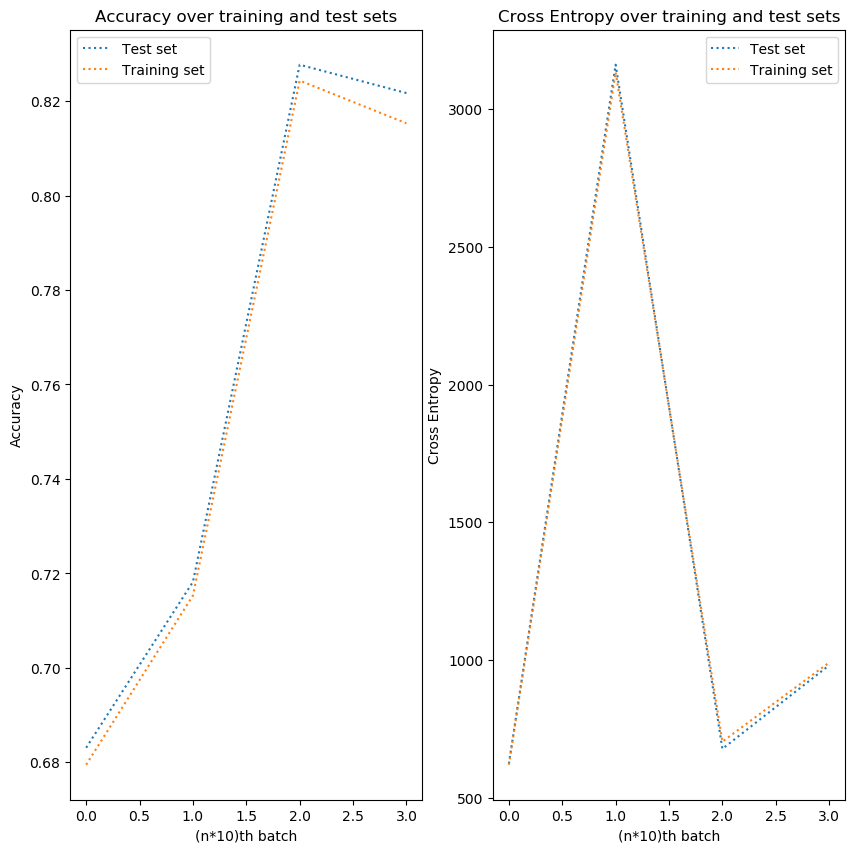

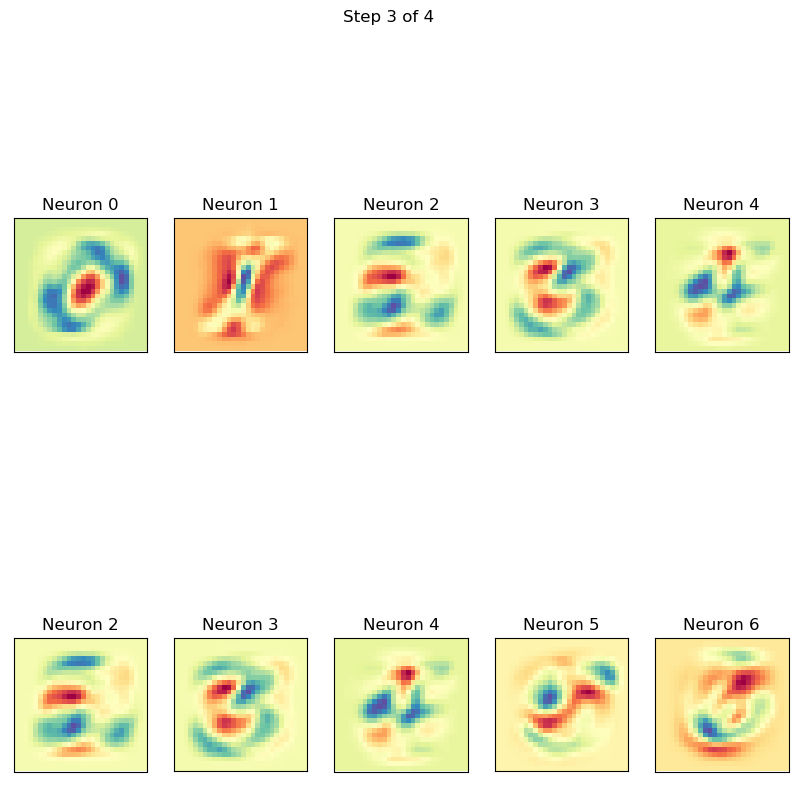

In [6]:
# Problem: We append the accuray every 10th step, so we may miss the last one
print('(Almost) final test accuracy: %f' % test_step_accuracy[-1])

# Plot entropy and accuray
f = plt.figure()
ax_acc = f.add_subplot(121)
ax_acc.set_title('Accuracy over training and test sets')
ax_acc.set_xlabel('(n*10)th batch')
ax_acc.set_ylabel('Accuracy')
ax_acc.plot(test_step_accuracy, linestyle=':', label='Test set')
ax_acc.plot(training_step_accuracy, linestyle=':', label='Training set')
ax_acc.legend()

ax_entropy = f.add_subplot(122)
ax_entropy.set_title('Cross Entropy over training and test sets')
ax_entropy.set_xlabel('(n*10)th batch')
ax_entropy.set_ylabel('Cross Entropy')
ax_entropy.plot(test_step_entropy, linestyle=':', label='Test set')
ax_entropy.plot(training_step_entropy, linestyle=':', label='Training set')
ax_entropy.legend()
plt.show()

# Plot weights interactively
rows, cols = (2, 5)
f2, axarr = plt.subplots(rows, cols)
plt.ion()
for row in range(2):
    for col in range(5):
        ax = axarr[row][col]
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

for i in range(len(weights)):
    current_weights = weights[i]
    for row in range(2):
        for col in range(5):
            f2.suptitle('Step %d of %d' % (i, len(weights)))
            ax = axarr[row][col]
            ax.cla()
            index = row * rows + col
            ax.set_title('Neuron %d' % index)
            # there's many diverging cmaps
            # (https://matplotlib.org/examples/color/colormaps_reference.html)
            ax.imshow(current_weights[..., index], cmap='Spectral')
    # pause so that it always takes 5 seconds
    # Note: The animation seems to slow down linearly, unless we clear the
    # axes (see above).
    # Uncomment this function if you have pyplot > v2.11. Details:
    #     https://stackoverflow.com/questions/46982150/matplotlib-pyplot-global-name-time-is-not-defined-error
    # also, this doesn't seem to run in notebooks. Run the accompanying exercise5.py file instead.
    #       plt.pause(5 / len(weights)) 